# Download and prepare the data

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop

**Constants**

In [2]:
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
batch_size = 32
embedding_dim = 100

**Load the IMDB dataset & tokenize the data**

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1641221/1641221 [==============================] - 0s 0us/step


**Preprocess the data, validate & train the data**

In [5]:
train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen)
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen)

In [6]:
training_samples = 100
x_train = train_data[:training_samples]
y_train = train_labels[:training_samples]

In [7]:
x_val = train_data[training_samples: training_samples + 10000]
y_val = train_labels[training_samples: training_samples + 10000]

In [8]:
model_embedding = Sequential()
model_embedding.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model_embedding.add(Flatten())
model_embedding.add(Dense(32, activation='relu'))
model_embedding.add(Dense(1, activation='sigmoid'))

model_embedding.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['acc'])

In [9]:
history_embedding = model_embedding.fit(x_train, y_train,
                                        epochs=10,
                                        batch_size=batch_size,
                                        validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 3s 341ms/step - loss: 0.6969 - acc: 0.4500 - val_loss: 0.6921 - val_acc: 0.5188
Epoch 2/10
4/4 [==============================] - 1s 270ms/step - loss: 0.5631 - acc: 0.9600 - val_loss: 0.6951 - val_acc: 0.5096
Epoch 3/10
4/4 [==============================] - 1s 274ms/step - loss: 0.4378 - acc: 1.0000 - val_loss: 0.6994 - val_acc: 0.5095
Epoch 4/10
4/4 [==============================] - 1s 274ms/step - loss: 0.3036 - acc: 1.0000 - val_loss: 0.7259 - val_acc: 0.5161
Epoch 5/10
4/4 [==============================] - 1s 264ms/step - loss: 0.2077 - acc: 0.9800 - val_loss: 0.7220 - val_acc: 0.5108
Epoch 6/10
4/4 [==============================] - 1s 266ms/step - loss: 0.1315 - acc: 1.0000 - val_loss: 0.7140 - val_acc: 0.5130
Epoch 7/10
4/4 [==============================] - 1s 269ms/step - loss: 0.0870 - acc: 1.0000 - val_loss: 0.7293 - val_acc: 0.5104
Epoch 8/10
4/4 [==============================] - 1s 271ms/step - loss: 0.0593 - acc: 1.00

**Plot the results**

In [10]:
import matplotlib.pyplot as plt

In [11]:
acc = history_embedding.history['acc']
val_acc = history_embedding.history['val_acc']
loss = history_embedding.history['loss']
val_loss = history_embedding.history['val_loss']
epochs = range(1, len(acc) + 1)

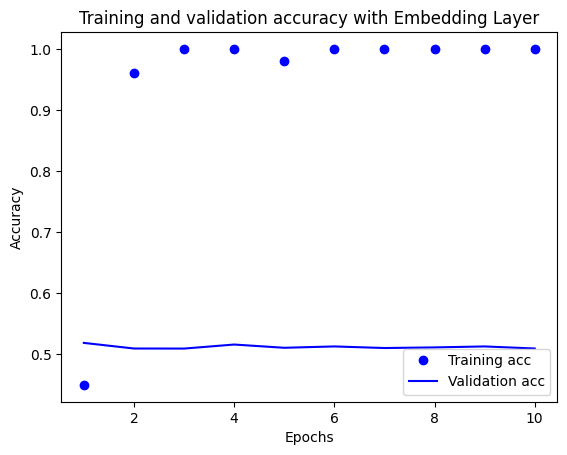

In [12]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with Embedding Layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

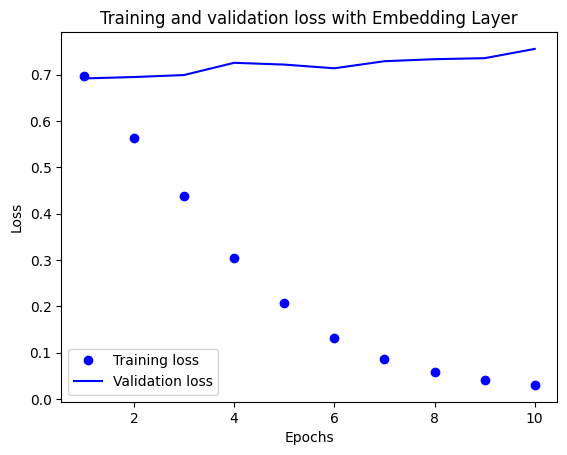

In [13]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with Embedding Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Download GloVe embeddings from https://nlp.stanford.edu/projects/glove/

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -qq /content/gdrive/MyDrive/glove.6B.zip

Mounted at /content/gdrive


In [15]:
glove_dir = 'glove.6B.100d.txt'

In [16]:
embeddings_index = {}
with open(glove_dir, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

**Create embedding matrix**

In [17]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

**Define the model with a pretrained word embedding (GloVe)**

In [18]:
model_pretrained_embedding = Sequential()
model_pretrained_embedding.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model_pretrained_embedding.add(Flatten())
model_pretrained_embedding.add(Dense(32, activation='relu'))
model_pretrained_embedding.add(Dense(1, activation='sigmoid'))

model_pretrained_embedding.layers[0].set_weights([embedding_matrix])
model_pretrained_embedding.layers[0].trainable = False

model_pretrained_embedding.compile(optimizer='rmsprop',
                                   loss='binary_crossentropy',
                                   metrics=['acc'])

**Train the model with pretrained embedding**

In [19]:
history_pretrained_embedding = model_pretrained_embedding.fit(x_train, y_train,
                                                              epochs=10,
                                                              batch_size=batch_size,
                                                              validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 1s 216ms/step - loss: 2.2641 - acc: 0.4600 - val_loss: 0.8249 - val_acc: 0.4957
Epoch 2/10
4/4 [==============================] - 1s 168ms/step - loss: 0.7074 - acc: 0.6700 - val_loss: 0.9700 - val_acc: 0.5010
Epoch 3/10
4/4 [==============================] - 1s 169ms/step - loss: 0.4010 - acc: 0.7800 - val_loss: 0.7421 - val_acc: 0.5066
Epoch 4/10
4/4 [==============================] - 1s 172ms/step - loss: 0.2278 - acc: 0.9300 - val_loss: 1.6383 - val_acc: 0.4972
Epoch 5/10
4/4 [==============================] - 1s 169ms/step - loss: 0.4232 - acc: 0.7300 - val_loss: 0.7299 - val_acc: 0.5170
Epoch 6/10
4/4 [==============================] - 1s 168ms/step - loss: 0.1018 - acc: 1.0000 - val_loss: 0.7408 - val_acc: 0.5117
Epoch 7/10
4/4 [==============================] - 1s 167ms/step - loss: 0.0685 - acc: 1.0000 - val_loss: 0.7804 - val_acc: 0.5155
Epoch 8/10
4/4 [==============================] - 0s 164ms/step - loss: 0.0532 - acc: 1.00

**Evaluate the model on test data**

In [20]:
loss_pretrained_embedding, acc_pretrained_embedding = model_pretrained_embedding.evaluate(test_data, test_labels)
print(f"Pretrained Embedding Model - Test Loss: {loss_pretrained_embedding:.4f}, Test Accuracy: {acc_pretrained_embedding:.4f}")

782/782 [==============================] - 1s 2ms/step - loss: 1.0511 - acc: 0.5103
Pretrained Embedding Model - Test Loss: 1.0511, Test Accuracy: 0.5103


# Changing the number of training samples

In [21]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.metrics import accuracy_score

**Constants**

In [22]:
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
embedding_dim = 100
batch_size = 32
epochs = 10

**Load the dataset & tokenize the data**

In [23]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

In [24]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

**Preprocess the data**

In [25]:
x_train = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen)

**Varying number of training samples**

In [26]:
sample_sizes = [300]
results = {'embedding_layer': [], 'pretrained_embedding': []}

for size in sample_sizes:
    y_train = train_labels[:size]
    y_test = test_labels

**Model with Embedding Layer**

In [27]:
model_embedding = Sequential()
model_embedding.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model_embedding.add(Flatten())
model_embedding.add(Dense(32, activation='relu'))
model_embedding.add(Dense(1, activation='sigmoid'))

In [28]:
model_embedding.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['acc'])

In [29]:
history_embedding = model_embedding.fit(x_train[:size], y_train,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_split=0.2,
                                            verbose=0)

In [30]:
y_pred_embedding = (model_embedding.predict(x_test) > 0.5).astype("int32")
acc_embedding = accuracy_score(y_test, y_pred_embedding)
results['embedding_layer'].append(acc_embedding)

782/782 [==============================] - 1s 1ms/step


**Model with Pretrained Embedding**

In [31]:
embedding_matrix = np.zeros((max_features, embedding_dim))
glove_dir = 'glove.6B.100d.txt'

In [32]:
with open(glove_dir, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index and word_index[word] < max_features:
                embedding_matrix[word_index[word]] = np.asarray(values[1:], dtype='float32')

In [33]:
model_pretrained_embedding = Sequential()
model_pretrained_embedding.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model_pretrained_embedding.add(Flatten())
model_pretrained_embedding.add(Dense(32, activation='relu'))
model_pretrained_embedding.add(Dense(1, activation='sigmoid'))

In [34]:
model_pretrained_embedding.layers[0].set_weights([embedding_matrix])
model_pretrained_embedding.layers[0].trainable = False

In [35]:
model_pretrained_embedding.compile(optimizer='rmsprop',
                                       loss='binary_crossentropy',
                                       metrics=['acc'])

In [36]:
history_pretrained_embedding = model_pretrained_embedding.fit(x_train[:size], y_train,
                                                                epochs=epochs,
                                                                batch_size=batch_size,
                                                                validation_split=0.2,
                                                                verbose=0)

In [37]:
y_pred_pretrained = (model_pretrained_embedding.predict(x_test) > 0.5).astype("int32")
acc_pretrained = accuracy_score(y_test, y_pred_pretrained)
results['pretrained_embedding'].append(acc_pretrained)

782/782 [==============================] - 1s 1ms/step


In [38]:
print("Results:")
for size, result in zip(sample_sizes, zip(results['embedding_layer'], results['pretrained_embedding'])):
    print(f"Training samples: {size}")
    print(f"Embedding Layer Accuracy: {result[0]:.4f}")
    print(f"Pretrained Embedding Accuracy: {result[1]:.4f}")
    print()

Results:
Training samples: 300
Embedding Layer Accuracy: 0.5276
Pretrained Embedding Accuracy: 0.5122



# Fine-tuning the model

In [39]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout
from sklearn.metrics import accuracy_score

In [40]:
# Constants
max_features = 10000  # Consider only the top 10,000 words
maxlen = 150  # Cutoff reviews after 150 words
embedding_dim = 100
batch_size = 32
epochs = 15  # Increase epochs for more training

In [41]:
# Load the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

In [42]:
# Preprocess the data
x_train = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen)

In [44]:
# Model with Embedding Layer
model_embedding = Sequential()
model_embedding.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model_embedding.add(LSTM(128, return_sequences=True))  # Use LSTM with return_sequences=True
model_embedding.add(LSTM(128))  # Another LSTM layer
model_embedding.add(Dense(64, activation='relu'))
model_embedding.add(Dropout(0.5))  # Dropout regularization
model_embedding.add(Dense(1, activation='sigmoid'))

In [45]:
model_embedding.compile(optimizer='adam',  # Try different optimizers like Adam
                        loss='binary_crossentropy',
                        metrics=['acc'])

In [46]:
history_embedding = model_embedding.fit(x_train, train_labels,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_split=0.2,
                                        verbose=1)

Epoch 1/15
625/625 [==============================] - 47s 69ms/step - loss: 0.4711 - acc: 0.7825 - val_loss: 0.3777 - val_acc: 0.8438
Epoch 2/15
625/625 [==============================] - 14s 22ms/step - loss: 0.2955 - acc: 0.8860 - val_loss: 0.3656 - val_acc: 0.8470
Epoch 3/15
625/625 [==============================] - 12s 19ms/step - loss: 0.2086 - acc: 0.9234 - val_loss: 0.3997 - val_acc: 0.8526
Epoch 4/15
625/625 [==============================] - 10s 16ms/step - loss: 0.1548 - acc: 0.9434 - val_loss: 0.4979 - val_acc: 0.8266
Epoch 5/15
625/625 [==============================] - 11s 18ms/step - loss: 0.1124 - acc: 0.9617 - val_loss: 0.5146 - val_acc: 0.8292
Epoch 6/15
625/625 [==============================] - 9s 15ms/step - loss: 0.0863 - acc: 0.9722 - val_loss: 0.6208 - val_acc: 0.8418
Epoch 7/15
625/625 [==============================] - 11s 17ms/step - loss: 0.0617 - acc: 0.9801 - val_loss: 0.6801 - val_acc: 0.8360
Epoch 8/15
625/625 [==============================] - 9s 14ms/s

In [47]:
# Evaluate model
loss, accuracy = model_embedding.evaluate(x_test, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

782/782 [==============================] - 4s 6ms/step - loss: 1.0048 - acc: 0.8360
Test Accuracy: 83.60%


In [48]:
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
# Define the data
results_data = {
    "Model": ["Pretrained Embedding Initial", "Fine-tuned Model"],
    "Test Accuracy": [51.03, 83.60]
}

In [50]:
results_df = pd.DataFrame(results_data)

(0.0, 100.0)

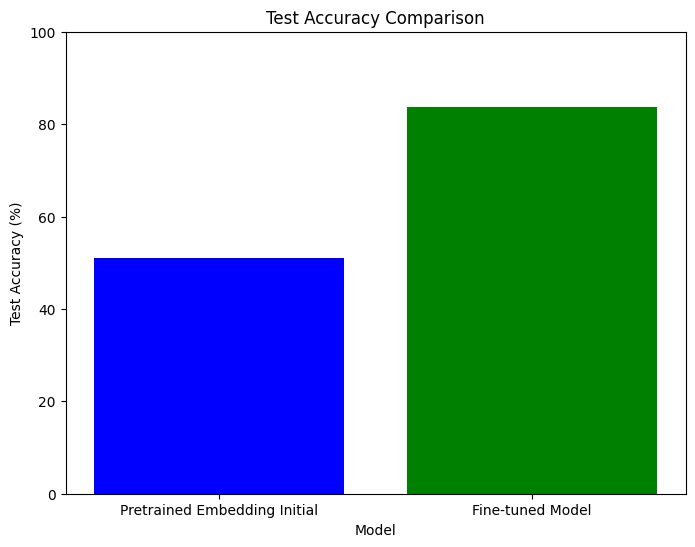

In [51]:
# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(results_df["Model"], results_df["Test Accuracy"], color=['blue', 'green'])
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison")
plt.ylim(0, 100)

In [ ]:
# Add text labels to the bars
for i, val in enumerate(results_df["Test Accuracy"]):
    plt.text(i, val + 1, f"{val:.2f}%", horizontalalignment='center', verticalalignment='bottom')

In [53]:
# Show the plot
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [54]:
# Display the results table
print("Results Table:")
print(results_df)

Results Table:
                          Model  Test Accuracy
0  Pretrained Embedding Initial          51.03
1              Fine-tuned Model          83.60
